In [4]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import numpy as np
import warnings
import requests

In [5]:
warnings.filterwarnings('ignore')

In [6]:
# function to connect to wiki_dbs and query
def connect_and_query(wiki_name, query, cnf_path = "/home/paws/.my.cnf"):
    
    conn = pymysql.connect(host = wiki_name + '.analytics.db.svc.wikimedia.cloud',
                           read_default_file = cnf_path,
                           database = wiki_name + '_p')
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
    
    conn.close()
    return data

In [7]:
wikis = ['tewiki', 'hiwiki', 'mlwiki']
all_dfs = []

**Proportion of new users activated (last 30 days)**

**count of the users who edit in last 30 days 
at least 1 edit 
at least 5 edits**

Querying tewiki...
Querying hiwiki...
Querying mlwiki...
Activation metrics by wiki:


,wiki,total_new_users,new_users_with_1_edit,new_users_with_5_edits,activation_rate_1_edit_percent
0,tewiki,497,45,7,9.05
1,hiwiki,4306,1261,92,29.28
2,mlwiki,553,49,3,8.86


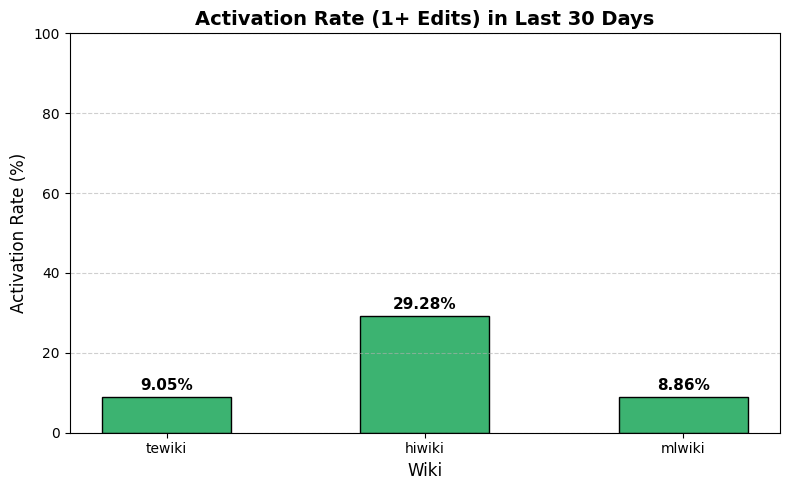

In [30]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# SQL query for new user activation metrics
query = """
WITH new_user_edit_counts AS (
    SELECT 
        u.user_id,
        u.user_registration,
        COALESCE(COUNT(r.rev_id), 0) AS edit_count
    FROM user u
    LEFT JOIN actor a ON u.user_id = a.actor_user
    LEFT JOIN revision r ON a.actor_id = r.rev_actor
    WHERE u.user_registration >= NOW() - INTERVAL 30 DAY
    GROUP BY u.user_id, u.user_registration
)
SELECT 
    COUNT(*) AS total_new_users,
    SUM(CASE WHEN edit_count >= 1 THEN 1 ELSE 0 END) AS new_users_with_1_edit,
    SUM(CASE WHEN edit_count >= 5 THEN 1 ELSE 0 END) AS new_users_with_5_edits,
    ROUND(
        (SUM(CASE WHEN edit_count >= 1 THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 
        2
    ) AS activation_rate_1_edit_percent
FROM new_user_edit_counts;
"""

# Wikis to query
wikis = ['tewiki','hiwiki', 'mlwiki']
results = []

for wiki in wikis:
    print(f"Querying {wiki}...")
    output = connect_and_query(wiki, query)
    
    if output:
        row = list(output[0])
        row.insert(0, wiki)
        results.append(row)
    else:
        print(f"No data returned from {wiki}")

# Plot if data is available
if results:
    df = pd.DataFrame(results, columns=[
        'wiki',
        'total_new_users',
        'new_users_with_1_edit',
        'new_users_with_5_edits',
        'activation_rate_1_edit_percent'
    ])

    print("Activation metrics by wiki:")
    display(df)  # or use print(df) outside notebooks

    # Plot activation rate bar chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(df['wiki'], df['activation_rate_1_edit_percent'],
                   color='mediumseagreen', edgecolor='black', width=0.5)

    # Add value labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1,
                 f'{height:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.title('Activation Rate (1+ Edits) in Last 30 Days', fontsize=14, weight='bold')
    plt.xlabel('Wiki', fontsize=12)
    plt.ylabel('Activation Rate (%)', fontsize=12)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No activation data to display.")


**top edited content pages for the selected time range**

In [8]:
# Define SQL query to get the top 10 most edited pages in main namespace (namespace 0)
# Grouped by edit date and page, ordered by most edits
query = """
SELECT 
    DATE(r.rev_timestamp) AS edit_date,
    p.page_id, 
    p.page_title, 
    COUNT(DISTINCT r.rev_id) AS edit_count
FROM revision r
JOIN page p ON r.rev_page = p.page_id
WHERE p.page_namespace = 0
GROUP BY DATE(r.rev_timestamp), p.page_id, p.page_title
ORDER BY edit_count DESC
LIMIT 10;
"""


In [9]:
# Import necessary Python libraries
import pandas as pd
from IPython.display import display, HTML

# Note: Ensure you have a function like `connect_and_query(wiki, query)` defined
# which handles database connection and returns results as a list of tuples


In [10]:
# Loop through each wiki in the list and run the query
for wiki in wikis:
    print(f"Querying data for {wiki}...")
    
    # Execute query and get results
    output = connect_and_query(wiki, query)
    
    if output:
        # Convert raw query results to DataFrame
        df = pd.DataFrame(output, columns=['edit_date', 'page_id', 'page_title', 'edit_count'])
        
        # Decode byte strings (common with multilingual wikis) into readable text
        df['page_title'] = df['page_title'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

        # Create full Wikipedia page URLs
        df['page_url'] = df.apply(
            lambda row: f"https://{wiki.replace('wiki','')}.wikipedia.org/wiki/{str(row['page_title']).replace(' ', '_')}",
            axis=1
        )

        # Generate clickable HTML links to the articles
        df['article_link'] = df.apply(
            lambda row: f"<a href='{row['page_url']}' target='_blank'>View</a>",
            axis=1
        )

        # Display a heading and the table in notebook or app
        print(f"Showing top edited pages for {wiki}")
        display(HTML(f"<h3>{wiki.upper()} – Top 10 Edited Pages</h3>"))
        display(HTML(df[['edit_date', 'page_title', 'edit_count', 'article_link']].to_html(escape=False, index=False)))

    else:
        print(f"No data retrieved for {wiki}")


Querying data for tewiki...
Showing top edited pages for tewiki


edit_date,page_title,edit_count,article_link
2015-10-20,భారతదేశ_ప్రయాణీకుల_రైళ్లు_జాబితా,435,View
2019-01-04,భారతీయ_రైల్వే_స్టేషన్ల_జాబితా,340,View
2018-06-25,భారతీయ_రైల్వే_స్టేషన్ల_జాబితా,311,View
2017-06-08,భారతీయ_చక్రవర్తుల_జాబితా,309,View
2015-10-18,భారతదేశ_ప్రయాణీకుల_రైళ్లు_జాబితా,307,View
2015-10-21,భారతదేశ_ప్రయాణీకుల_రైళ్లు_జాబితా,297,View
2015-10-16,భారతదేశ_ప్రయాణీకుల_రైళ్లు_జాబితా,292,View
2019-01-19,భారతీయ_రైల్వే_స్టేషన్ల_జాబితా,280,View
2018-06-13,భారతీయ_రైల్వే_స్టేషన్ల_జాబితా,276,View
2024-12-03,భక్త్_బులంద్_షా,261,View


Querying data for hiwiki...
Showing top edited pages for hiwiki


edit_date,page_title,edit_count,article_link
2016-07-15,2016_नीस_हमला,377,View
2023-05-09,सुंदर_पिचाई,219,View
2021-08-30,आल्हा,217,View
2023-04-19,डीडी_न्यूज़,216,View
2010-06-17,राशि_और_रत्न,204,View
2021-08-30,आल्ह-खण्ड,198,View
2021-08-31,आल्ह-खण्ड,195,View
2021-08-31,आल्हा,191,View
2016-07-14,2016_नीस_हमला,189,View
2021-08-31,ऊदल,185,View


Querying data for mlwiki...
Showing top edited pages for mlwiki


edit_date,page_title,edit_count,article_link
2016-05-19,പതിനാലാം_കേരളനിയമസഭ,179,View
2014-06-06,ചൈനയുടെ_ചരിത്രം,175,View
2016-09-02,ബ്ലാക്ക്_ജൂലൈ,151,View
2011-08-06,എമിലി_ഡിക്കിൻസൺ,150,View
2017-01-25,കേരളത്തിലെ_ചിത്രശലഭങ്ങൾ,137,View
2012-12-26,സൗദി_അറേബ്യ,134,View
2015-09-24,അങ്കമാലിയിലെ_മാർ_അബ്രാഹം,134,View
2016-12-20,കേരളത്തിലെ_തുമ്പികൾ,133,View
2012-10-03,സൗദി_അറേബ്യ,129,View
2012-12-25,സൗദി_അറേബ്യ,128,View


**"- VE vs. wikitext:- Content Translation ,Section Translation"**

In [11]:

# SQL query for  Edit counts by tool 
query = """
SELECT 
    ctd.ctd_name AS edit_tool,
    COUNT(*) AS edit_count
FROM change_tag ct
JOIN change_tag_def ctd 
    ON ct.ct_tag_id = ctd.ctd_id  
JOIN revision r 
    ON ct.ct_rev_id = r.rev_id
WHERE ctd.ctd_name IN ('visualeditor', 'wikitext', 'contenttranslation', 'sectiontranslation')
GROUP BY ctd.ctd_name
ORDER BY edit_count DESC;
"""
wikis = ['tewiki', 'hiwiki', 'mlwiki']
all_data = []


Querying tewiki...
Querying hiwiki...
Querying mlwiki...


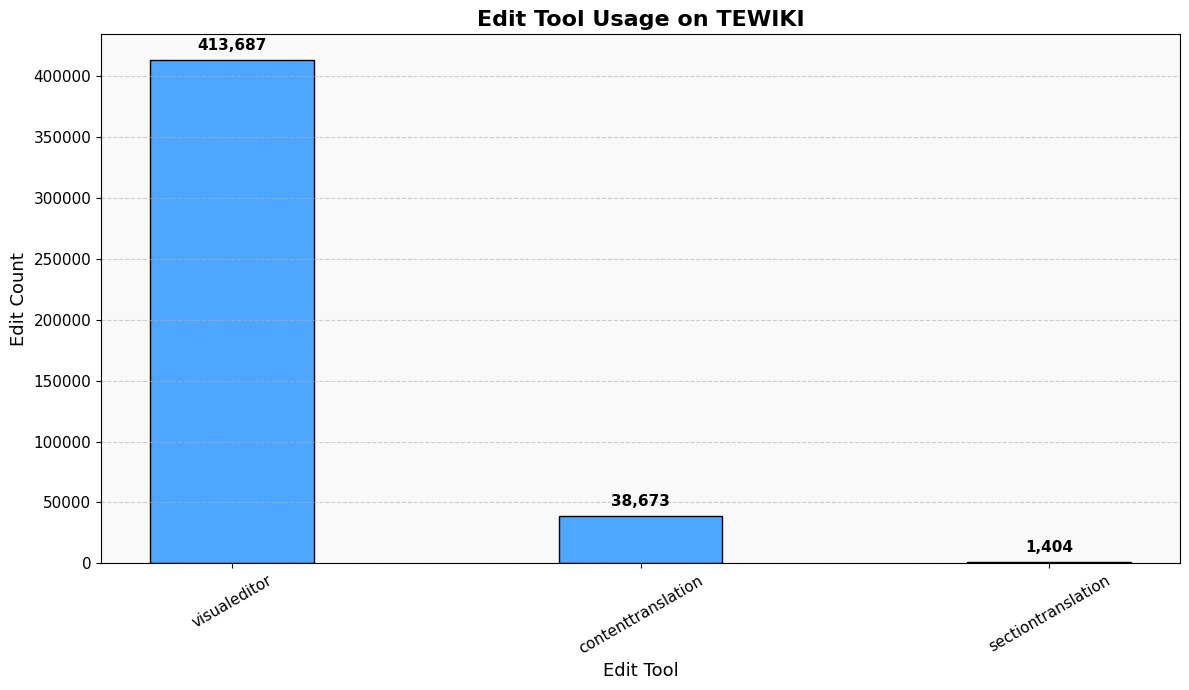

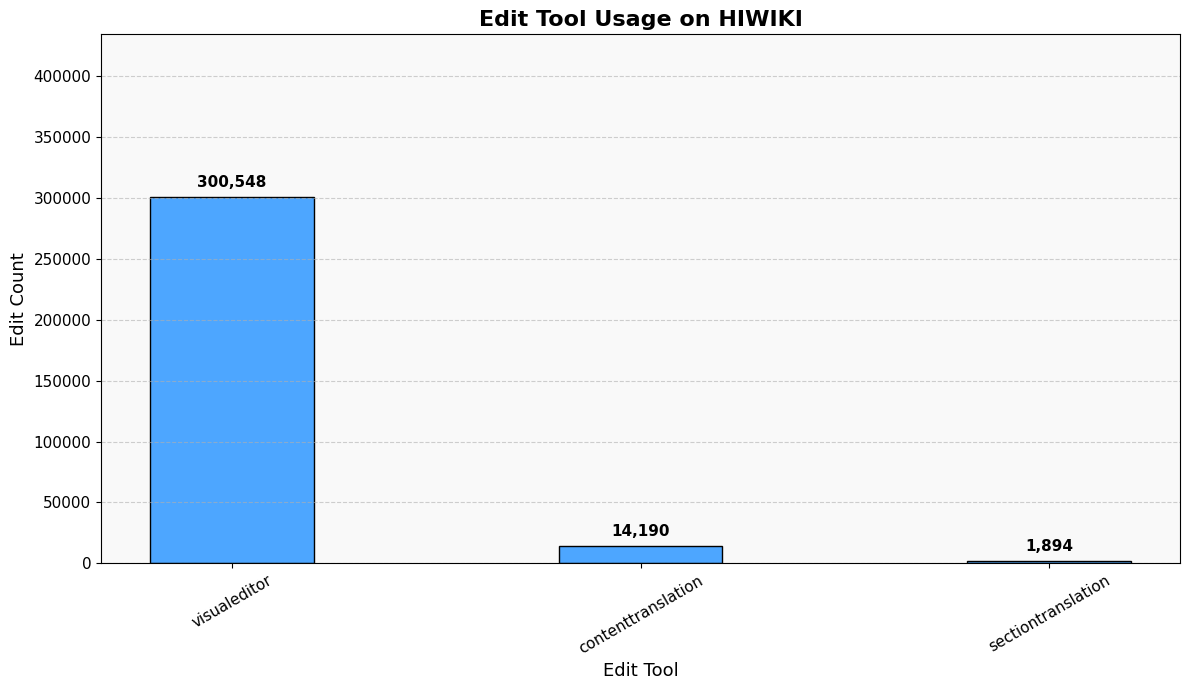

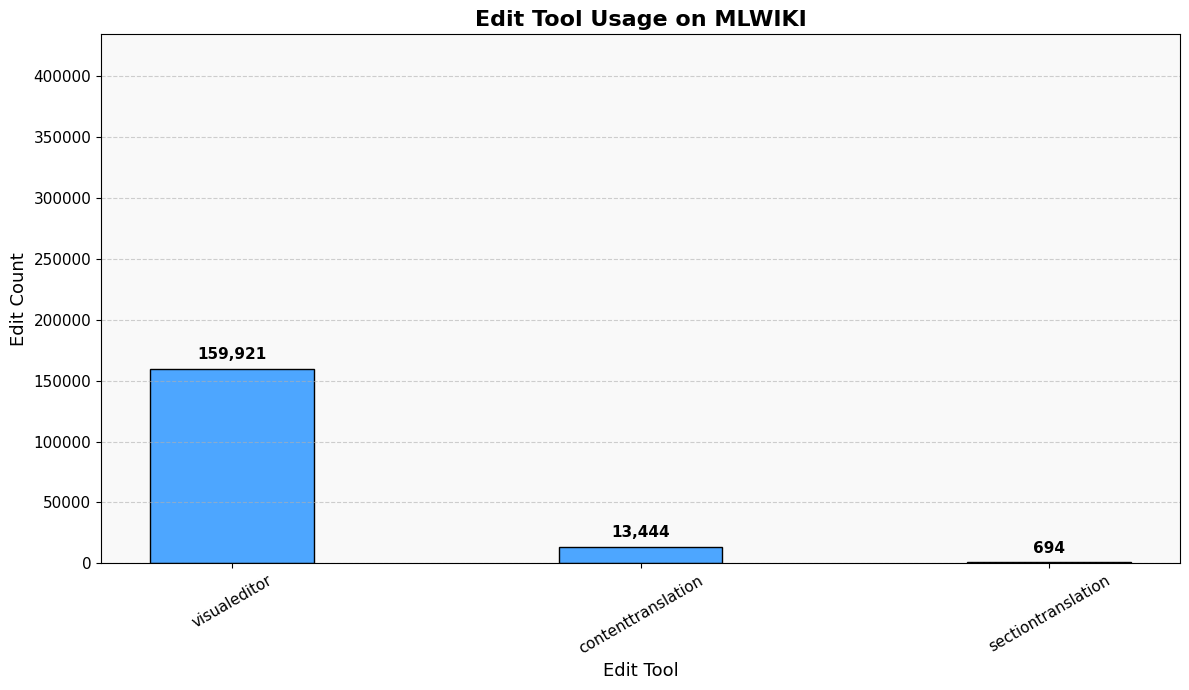

In [26]:
i
# Fetch and combine data
for wiki in wikis:
    print(f"Querying {wiki}...")
    output = connect_and_query(wiki, query)

    if output:
        df = pd.DataFrame(output, columns=['edit_tool', 'edit_count'])
        df['wiki'] = wiki
        all_data.append(df)
    else:
        print(f"No data from {wiki}")

# Plot each wiki
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    max_count = combined_df['edit_count'].max()

    for wiki in wikis:
        temp = combined_df[combined_df['wiki'] == wiki]

        # 🔸 Larger figure size
        fig, ax = plt.subplots(figsize=(12, 7))

        # 🔸 Bar chart with thinner bars
        bars = ax.bar(temp['edit_tool'], temp['edit_count'], 
                      color='#4da6ff', edgecolor='black', width=0.4)

        # 🔸 Annotate each bar with comma-separated labels
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:,}', 
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords='offset points',
                        ha='center', va='bottom',
                        fontsize=11, fontweight='bold')

        # Axis labels, title, and styling
        ax.set_title(f"Edit Tool Usage on {wiki.upper()}", fontsize=16, weight='bold')
        ax.set_xlabel("Edit Tool", fontsize=13)
        ax.set_ylabel("Edit Count", fontsize=13)
        ax.set_ylim(0, max_count + max_count * 0.05)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.set_facecolor('#f9f9f9')

        plt.xticks(rotation=30, fontsize=11)
        plt.yticks(fontsize=11)
        plt.tight_layout()
        plt.show()
else:
    print("No data available to plot.")
